# Multi-Class Classification Model for Forest Cover Type Using Python Take 3
### David Lowe
### August 9, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Forest Cover Type dataset is a multi-class classification situation where we are trying to predict one of the seven possible outcomes.

INTRODUCTION: This experiment tries to predict forest cover type from cartographic variables only. This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

The actual forest cover type for a given observation (30 x 30-meter cell) was determined from the US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from the US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

In iteration Take1, we established the baseline accuracy for comparison with future rounds of modeling.

In iteration Take2, we examined the feature selection technique of attribute importance ranking by using the Gradient Boosting algorithm. By selecting the most important attributes, we decreased the modeling time and still maintained a similar level of accuracy when compared to the baseline model.

In iteration Take3, we will examine the feature selection technique of recursive feature elimination (RFE) by using the Extra Trees algorithm. By selecting no more than 40 attributes, we hope to maintain a similar level of accuracy when compared to the baseline model.

ANALYSIS: From iteration Take1, the baseline performance of the machine learning algorithms achieved an average accuracy of 78.04%. Two algorithms (Bagged Decision Trees and Extra Trees) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Extra Trees turned in the top overall result and achieved an accuracy metric of 85.80%. By using the optimized parameters, the Extra Trees algorithm processed the testing dataset with an accuracy of 86.50%, which was even better than the predictions from the training data.

From iteration Take2, the performance of the machine learning algorithms achieved an average accuracy of 77.84%. Extra Trees achieved an accuracy metric of 85.80% with the training dataset and processed the testing dataset with an accuracy of 86.19%, which was even better than the predictions from the training data. At the importance level of 99%, the attribute importance technique eliminated 23 of 54 total attributes. The remaining 31 attributes produced a model that achieved a comparable accuracy compared to the baseline model. The modeling time went from 2 minutes 2 seconds down to 1 minute 41 seconds, a reduction of 17.2%.

From the current iteration, the performance of the machine learning algorithms achieved an average accuracy of 77.99%. Extra Trees achieved an accuracy metric of 85.97% with the training dataset and processed the testing dataset with an accuracy of 86.64%, which was even better than the predictions from the training data. The RFE technique eliminated 16 of 54 total attributes. The remaining 38 attributes produced a model that achieved a comparable accuracy compared to the baseline model. The modeling time went from 2 minutes 2 seconds down to 1 minute 58 seconds, a reduction of 3.2%.

CONCLUSION: For this iteration, the Extra Trees algorithm achieved the best overall results using the training and testing datasets. For this dataset, Extra Trees should be considered for further modeling.

Dataset Used: Covertype Data Set

Dataset ML Model: Multi-Class classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Covertype

One source of potential performance benchmarks: https://www.kaggle.com/c/forest-cover-type-prediction/overview

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem

### 1.a) Load ibraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
from datetime import datetime
from email.message import EmailMessage
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [2]:
# Create the random seed number for reproducible results
seedNum = 888

# Set up the number of CPU cores available for multi-thread processing
cpu_num = 6

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

In [3]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'accuracy'

In [4]:
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Multi-Class Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [5]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [6]:
startTimeScript = datetime.now()

dataset_path = 'https://www.kaggle.com/c/forest-cover-type-prediction/download/train.csv'
dest_file = os.path.basename(dataset_path)
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + 'downloaded!')
#     print('Unpacking ' + dest_file)
#     with zipfile.ZipFile(dest_file, 'r') as zip_ref:
#         zip_ref.extractall('.')
#     print(dest_file + 'unpacked!')

inputFile = dest_file
Xy_original_df = pd.read_csv(inputFile, sep=',', header=0, index_col=0)

In [7]:
# Take a peek at the dataframe after the import
Xy_original_df.head(10)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
6,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,2
7,2606,45,7,270,5,633,222,225,138,6256,...,0,0,0,0,0,0,0,0,0,5
8,2605,49,4,234,7,573,222,230,144,6228,...,0,0,0,0,0,0,0,0,0,5
9,2617,45,9,240,56,666,223,221,133,6244,...,0,0,0,0,0,0,0,0,0,5


In [8]:
Xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 1 to 15120
Data columns (total 55 columns):
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_Type1                            15120 non-null int64
Soil_T

In [9]:
print(Xy_original_df.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original_df.isnull().sum().sum())

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


### 1.d) Data Cleaning

In [10]:
# Not applicable for this iteration of the project

In [11]:
# Take a peek at the dataframe after the cleaning
Xy_original_df.head(10)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
6,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,2
7,2606,45,7,270,5,633,222,225,138,6256,...,0,0,0,0,0,0,0,0,0,5
8,2605,49,4,234,7,573,222,230,144,6228,...,0,0,0,0,0,0,0,0,0,5
9,2617,45,9,240,56,666,223,221,133,6244,...,0,0,0,0,0,0,0,0,0,5


In [12]:
Xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 1 to 15120
Data columns (total 55 columns):
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_Type1                            15120 non-null int64
Soil_T

In [13]:
print(Xy_original_df.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original_df.isnull().sum().sum())

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


### 1.e) Splitting Data into Training and Testing Sets

In [14]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [15]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if required
Xy_original_df = Xy_original_df.rename(columns={'Cover_Type': 'targetVar'})

In [16]:
# We create an attribute-only dataset (X_original_df) for various visualization operations
if targetCol == totCol:
    X_original_df = Xy_original_df.iloc[:,0:totAttr]
    y_original_df = Xy_original_df.iloc[:,totAttr]
else:
    X_original_df = Xy_original_df.iloc[:,1:totCol]
    y_original_df = Xy_original_df.iloc[:,0]
print("Xy_original_df.shape: {} X_original_df.shape: {}".format(Xy_original_df.shape, X_original_df.shape))

Xy_original_df.shape: (15120, 55) X_original_df.shape: (15120, 54)


### 1.f) Set up the parameters for data visualization

In [17]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [18]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [19]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [20]:
Xy_original_df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,targetVar
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


#### 2.a.ii) Dimensions of the dataset.

In [21]:
Xy_original_df.shape

(15120, 55)

#### 2.a.iii) Types of the attributes.

In [22]:
X_original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 1 to 15120
Data columns (total 54 columns):
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_Type1                            15120 non-null int64
Soil_T

In [23]:
X_original_df.dtypes

Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                            int64
Soil_Type9                      

#### 2.a.iv) Statistical summary of all attributes.

In [24]:
X_original_df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 2.a.v) Summarize the levels of the class attribute.

In [25]:
Xy_original_df.groupby('targetVar').size()

targetVar
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

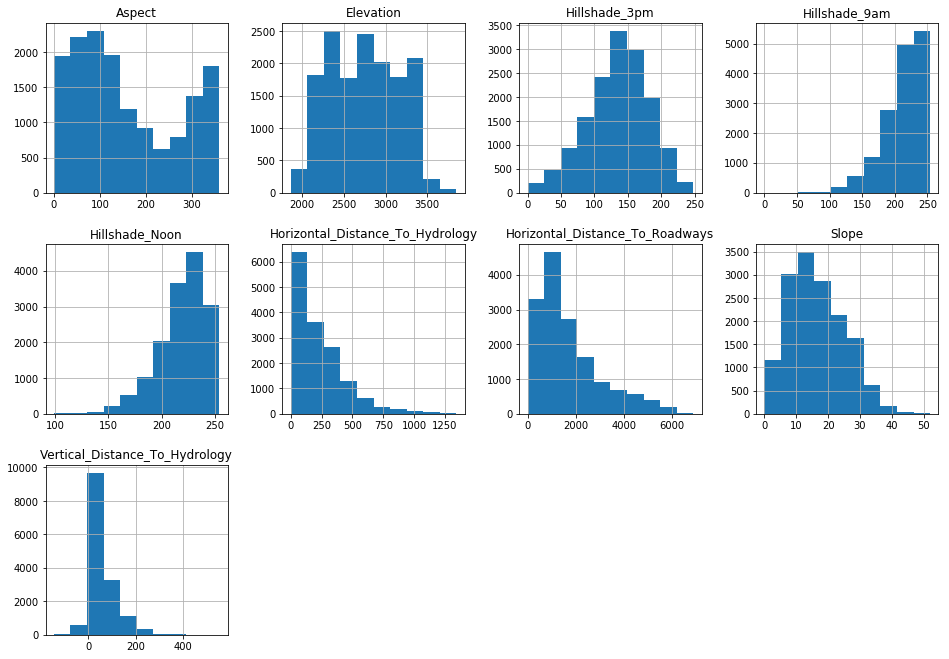

In [26]:
# Histograms for each attribute
X_original_df.iloc[:,0:9].hist(layout=(dispRow,dispCol))
plt.show()

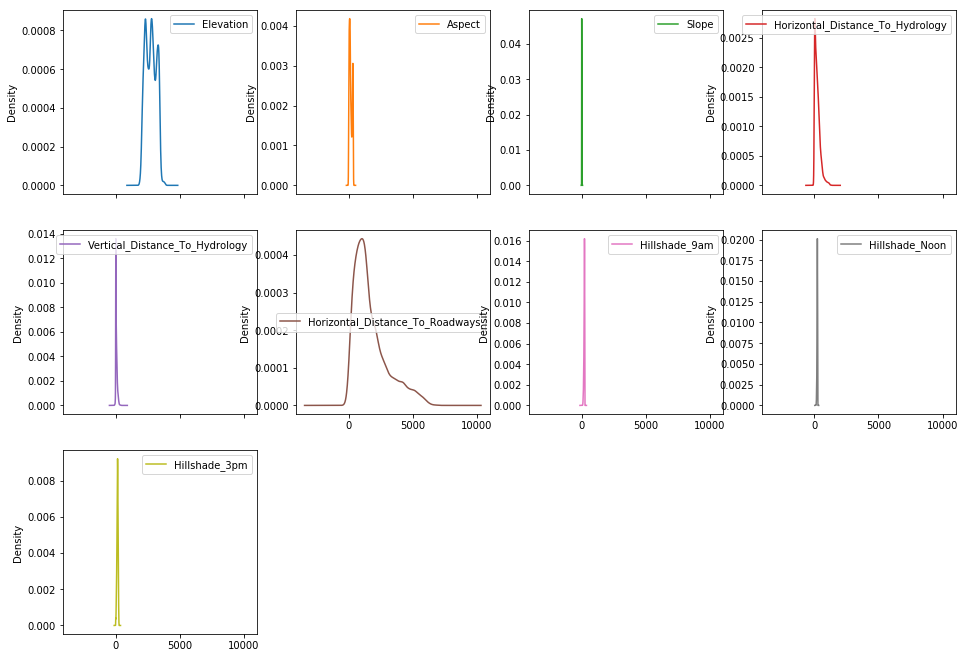

In [27]:
# Density plot for each attribute
X_original_df.iloc[:,0:9].plot(kind='density', subplots=True, layout=(dispRow,dispCol))
plt.show()

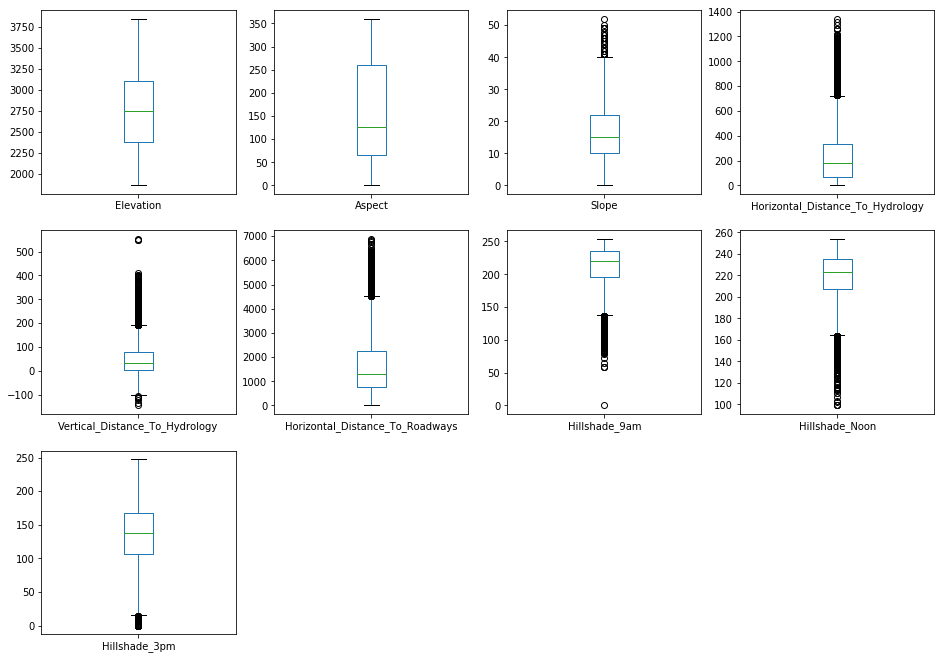

In [28]:
# Box and Whisker plot for each attribute
X_original_df.iloc[:,0:9].plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [29]:
# Scatterplot matrix
# scatter_matrix(X_original_df)
# plt.show()

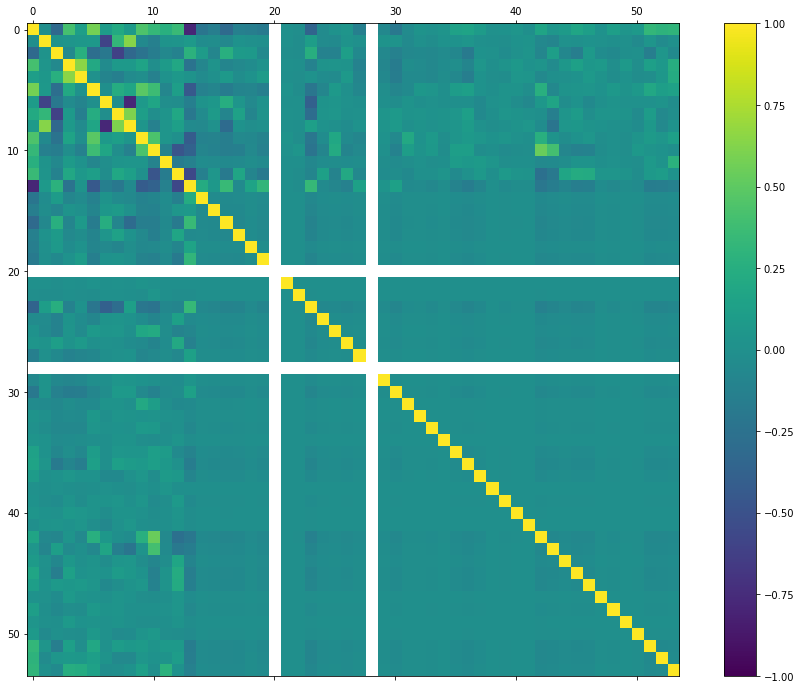

In [30]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [31]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [32]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Data Transforms

In [33]:
# Not applicable for this iteration of the project

In [34]:
### 3.b) Splitting Data into Training and Testing Sets

In [35]:
# Use 70% of the data to train the models and the remaining for testing/validation
validation_size = 0.30
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
print("Xy_original_df.shape: {} X_original_df.shape: {}".format(Xy_original_df.shape, X_original_df.shape))
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

Xy_original_df.shape: (15120, 55) X_original_df.shape: (15120, 54)
X_train_df.shape: (10584, 54) y_train_df.shape: (10584,)
X_test_df.shape: (4536, 54) y_test_df.shape: (4536,)


### 3.c) Feature Selection

The number of selected features: 38
The mask of selected features:
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False False  True
  True  True  True  True False False  True False False  True False  True
  True  True False False False False  True  True  True  True  True False
  True False False  True  True  True]
The ranking of selected features:
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  3  1 17 15 13  1
  1  1  1  1 16  2  1  5  7  1  9  1  1  1 14  6 11 10  1  1  1  1  1  8
  1 12  4  1  1  1]


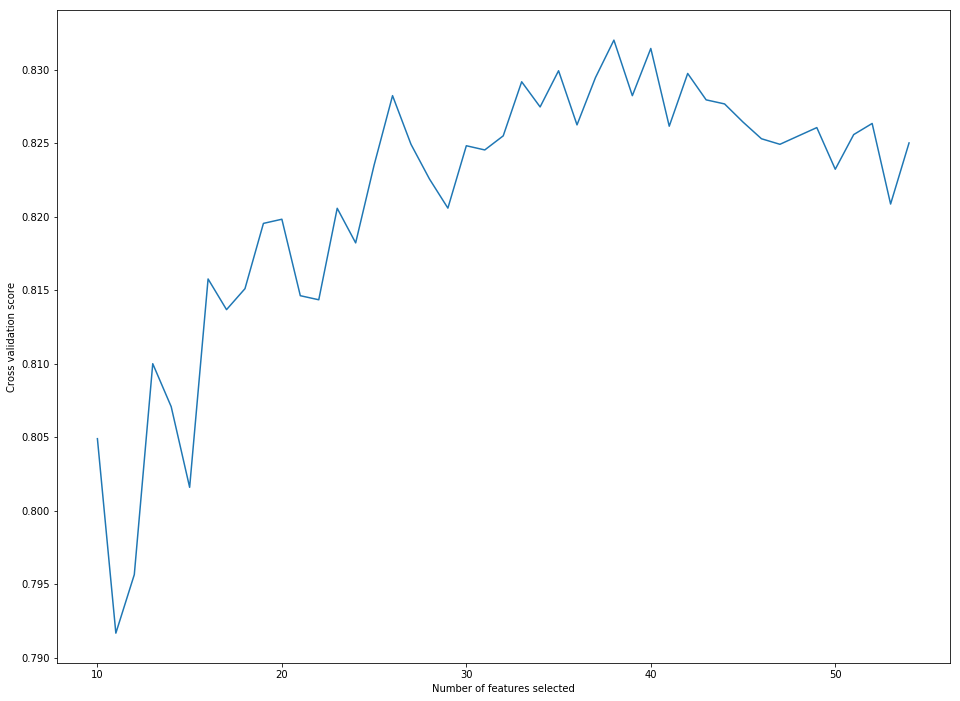

In [36]:
# Using the ensembled trees algorithm, we perform the Recursive Feature Elimination (RFE) technique
X_rfeVal = X_train_df.values
y_rfeVal = y_train_df.values.ravel()
estFunc = ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)
strFold = StratifiedKFold(n_splits=num_folds, random_state=seedNum)
minFeatures = 10
selector = RFECV(estimator=estFunc, step=1, min_features_to_select= minFeatures, cv=strFold, scoring=scoring)
selector = selector.fit(X_rfeVal, y_rfeVal)
print('The number of selected features:',selector.n_features_)
print('The mask of selected features:\n',selector.support_)
print('The ranking of selected features:\n',selector.ranking_)
plt.figure(figsize=(16,12))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(minFeatures, len(selector.grid_scores_) + minFeatures), selector.grid_scores_)
plt.show()

In [37]:
# Remove the unselected attributes from the training dataframes
X_train_df = X_train_df[X_train_df.columns[selector.support_]]
print(X_train_df.shape)
X_train_df.head()

(10584, 38)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type24,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type35,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
465,3041,243,14,513,50,5911,192,250,195,4636,...,0,1,0,0,0,0,0,0,0,0
7637,2691,27,8,153,20,2163,217,222,141,1939,...,0,0,0,0,1,0,0,0,0,0
121,2723,99,6,301,34,2109,230,232,136,5793,...,0,0,0,0,0,0,0,0,0,0
5956,2515,123,5,42,3,277,228,236,142,1627,...,0,0,0,0,0,0,0,0,0,0
13123,2397,114,10,30,11,875,238,230,122,999,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Remove the unselected attributes from the validation dataframes
X_test_df = X_test_df[X_test_df.columns[selector.support_]]
print(X_test_df.shape)
X_test_df.head()

(4536, 38)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type24,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type35,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
10367,3122,27,19,247,22,2841,208,194,116,1095,...,1,0,0,0,0,0,0,0,0,0
3050,2320,228,17,150,47,1087,193,253,194,837,...,0,0,0,0,0,0,0,0,0,0
10219,3139,344,14,42,5,2681,192,218,164,598,...,0,0,0,0,0,0,0,0,0,0
12427,2081,100,21,30,9,677,249,207,76,67,...,0,0,0,0,0,0,0,0,0,0
10859,2671,187,29,108,58,2121,209,246,150,484,...,0,0,0,0,0,0,0,0,0,0


### 3.d) Display the Final Datasets for Model-Building

In [39]:
# We finalize the training and testing datasets for the modeling activities
X_train = X_train_df.values
y_train = y_train_df.values
X_test = X_test_df.values
y_test = y_test_df.values
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (10584, 38) y_train.shape: (10584,)
X_test.shape: (4536, 38) y_test.shape: (4536,)


In [40]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and five ensemble algorithms:

Linear Algorithm: Linear Discriminant Analysis

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged Decision Trees, Random Forest, Extra Trees, Stochastic Gradient Boosting, and eXtreme Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set up modeling options and evaluation metrics

In [41]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
models.append(('KNN', KNeighborsClassifier(n_jobs=cpu_num)))
models.append(('BT', BaggingClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('RF', RandomForestClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('ET', ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)))
models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
# models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=cpu_num)))
results = []
names = []
metrics = []

In [42]:
# Generate model in turn
for name, model in models:
	if (notifyStatus): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	if (notifyStatus): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/lib/python3.7/site-packages/sklearn

LDA: 0.644366 (0.015768)
Model training time: 0:00:00.589222
CART: 0.774755 (0.012631)
Model training time: 0:00:01.203806
KNN: 0.784673 (0.015438)
Model training time: 0:00:02.026478
BT: 0.822658 (0.009443)
Model training time: 0:00:02.015546
RF: 0.821052 (0.010260)
Model training time: 0:00:01.679097
ET: 0.825775 (0.015287)
Model training time: 0:00:01.632419
GBM: 0.786282 (0.010322)
Model training time: 0:01:51.391790
Average metrics (accuracy) from all models: 0.7799372787345176
Total training time for all models: 0:01:51.392383


### 4.b) Spot-checking baseline algorithms

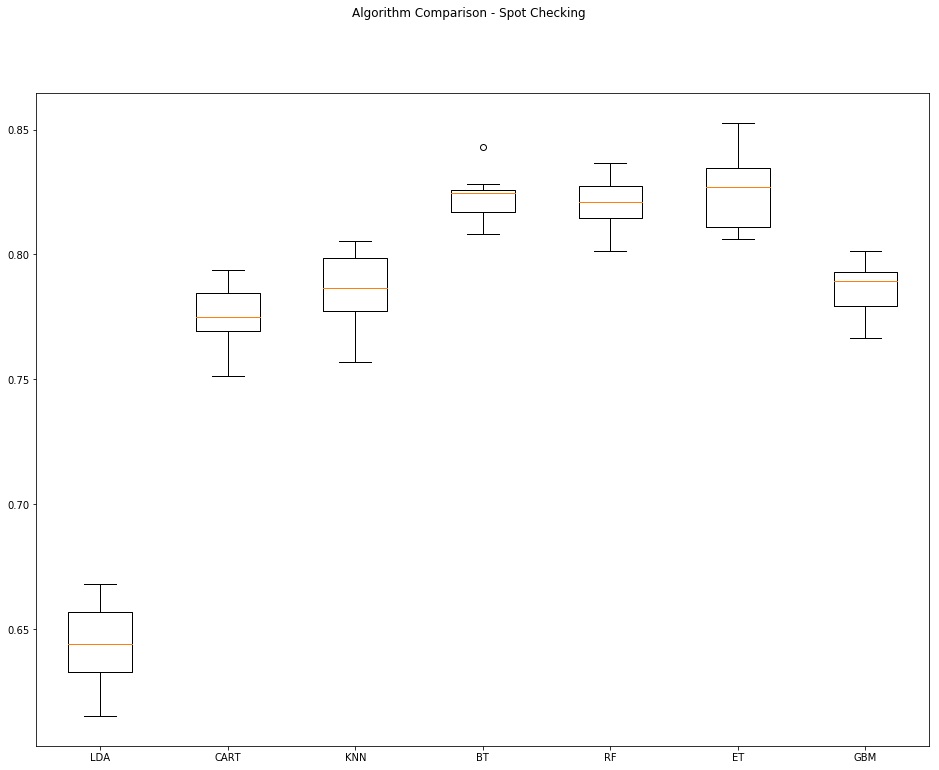

In [43]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [44]:
# Set up the comparison array
results = []
names = []

In [45]:
# Tuning algorithm #1 - Random Forest
if (notifyStatus): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(n_estimators=np.array([100, 200, 300, 400, 500]))
model1 = RandomForestClassifier(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('RF')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.858088 using {'n_estimators': 300}
0.853553 (0.009539) with: {'n_estimators': 100}
0.855537 (0.009553) with: {'n_estimators': 200}
0.858088 (0.010932) with: {'n_estimators': 300}
0.856576 (0.011485) with: {'n_estimators': 400}
0.857143 (0.011308) with: {'n_estimators': 500}
Model training time: 0:01:30.101521


In [46]:
# Tuning algorithm #2 - Extra Trees
if (notifyStatus): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([500, 600, 700, 800, 900]))
model2 = ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('ET')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: 0.859788 using {'n_estimators': 800}
0.857804 (0.016273) with: {'n_estimators': 500}
0.859316 (0.015208) with: {'n_estimators': 600}
0.859033 (0.015819) with: {'n_estimators': 700}
0.859788 (0.015429) with: {'n_estimators': 800}
0.859316 (0.014457) with: {'n_estimators': 900}
Model training time: 0:02:57.781947


### 5.b) Compare Algorithms After Tuning

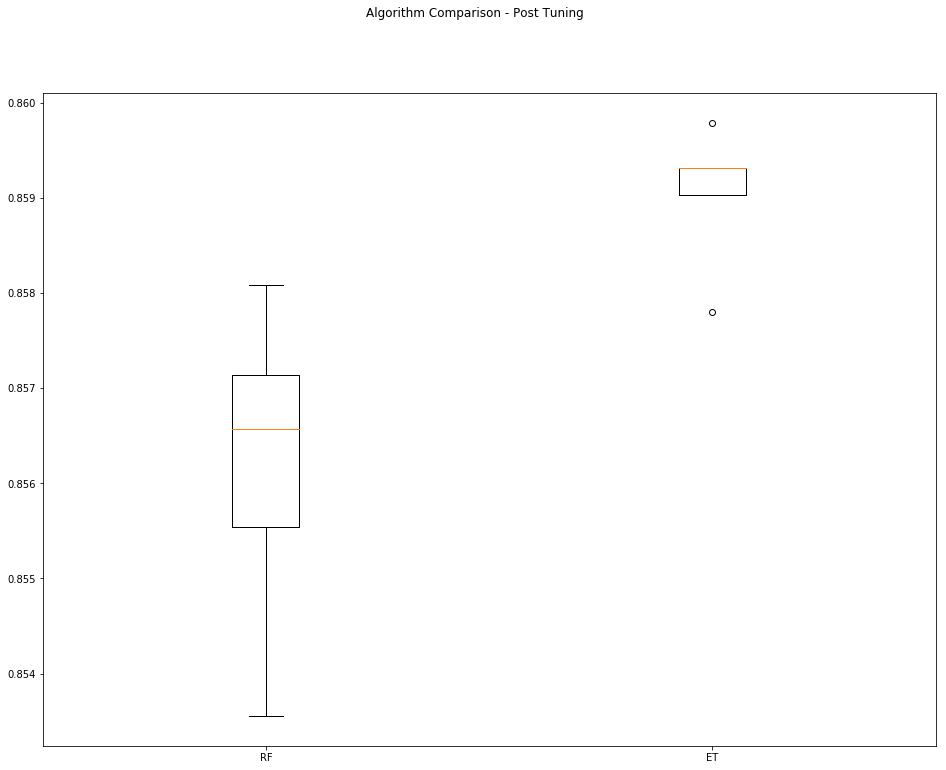

In [47]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [48]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on the testing dataset

In [49]:
model = RandomForestClassifier(n_estimators=300, random_state=seedNum, n_jobs=cpu_num)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8611111111111112
[[485  96   1   0  23   1  43]
 [115 465   9   0  54  16   2]
 [  0   3 509  30   4  71   0]
 [  0   0  12 657   0  10   0]
 [  0  19  13   0 595   8   0]
 [  1   6  58  13   2 599   0]
 [ 20   0   0   0   0   0 596]]
              precision    recall  f1-score   support

           1       0.78      0.75      0.76       649
           2       0.79      0.70      0.74       661
           3       0.85      0.82      0.84       617
           4       0.94      0.97      0.95       679
           5       0.88      0.94      0.91       635
           6       0.85      0.88      0.87       679
           7       0.93      0.97      0.95       616

   micro avg       0.86      0.86      0.86      4536
   macro avg       0.86      0.86      0.86      4536
weighted avg       0.86      0.86      0.86      4536



In [50]:
model = ExtraTreesClassifier(n_estimators=800, random_state=seedNum, n_jobs=cpu_num)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8664021164021164
[[488 100   1   0  24   1  35]
 [112 472   8   0  50  17   2]
 [  0   4 516  27   4  66   0]
 [  0   0  17 656   0   6   0]
 [  0  20   8   0 599   8   0]
 [  2   2  59  13   4 599   0]
 [ 16   0   0   0   0   0 600]]
              precision    recall  f1-score   support

           1       0.79      0.75      0.77       649
           2       0.79      0.71      0.75       661
           3       0.85      0.84      0.84       617
           4       0.94      0.97      0.95       679
           5       0.88      0.94      0.91       635
           6       0.86      0.88      0.87       679
           7       0.94      0.97      0.96       616

   micro avg       0.87      0.87      0.87      4536
   macro avg       0.86      0.87      0.86      4536
weighted avg       0.86      0.87      0.86      4536



### 6.b) Create standalone model on entire training dataset

In [51]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))

finalModel = ExtraTreesClassifier(n_estimators=300, random_state=seedNum, n_jobs=cpu_num)
finalModel.fit(X_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (15120, 38) y_complete.shape: (15120,)
Model training time: 0:00:01.673673


### 6.c) Save model for later use

In [52]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [53]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [54]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:09:18.274451
